# TP6 - Clasificador de imágenes con red convolucional

Guarda una copia de este cuaderno en tu Google Drive para poder editarla y ejecutarla.

El propio cuaderno será tu informe del trabajo. Puedes añadir tantas secciones de código y de texto como consideres necesario para resolver todos los ejercicios propuestos y analizar los resultados obtenidos. Una vez hayas terminado, descarga el notebook en formato ipynb y súbelo a Moodle en la tarea habilitada para el TP6 con el nombre NIP_TP6_CNN.ipynb

Es **obligatorio** que se **guarden los resultados de la evaluación** de cada celda de código (para no tener que volver a ejecutarlas). Por defecto los notebooks estan configurados así (Edit→Notebook Settings → NUNCA actives: Omit code cell output when saving this notebook) 

El Notebook incluye código de ejemplo para definir y entrenar una red convolucional con el dataset MNIST. Recuerda que **esta parte del trabajo se debe realizar con el dataset CIFAR 10**.

Imports necesarios para ejecutar el trabajo

In [ ]:
import time
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()

Carga del dataset MNIST

Importante observar como la organización de los datos es diferente que en el caso del perceptrón para poder aplicar bien las convoluciones

In [ ]:
# LOAD MNIST
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 32, 32

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test,  num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# Definicion de la red convolucional
model = Sequential()
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(164, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 512)       14336     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       1179904   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 256)       0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 164)               8229028   
                                                        

## Preguntas a responder de la celda anterior:

### 1.    Incluye un dibujo de la arquitectura de la red programada en la celda anterior.


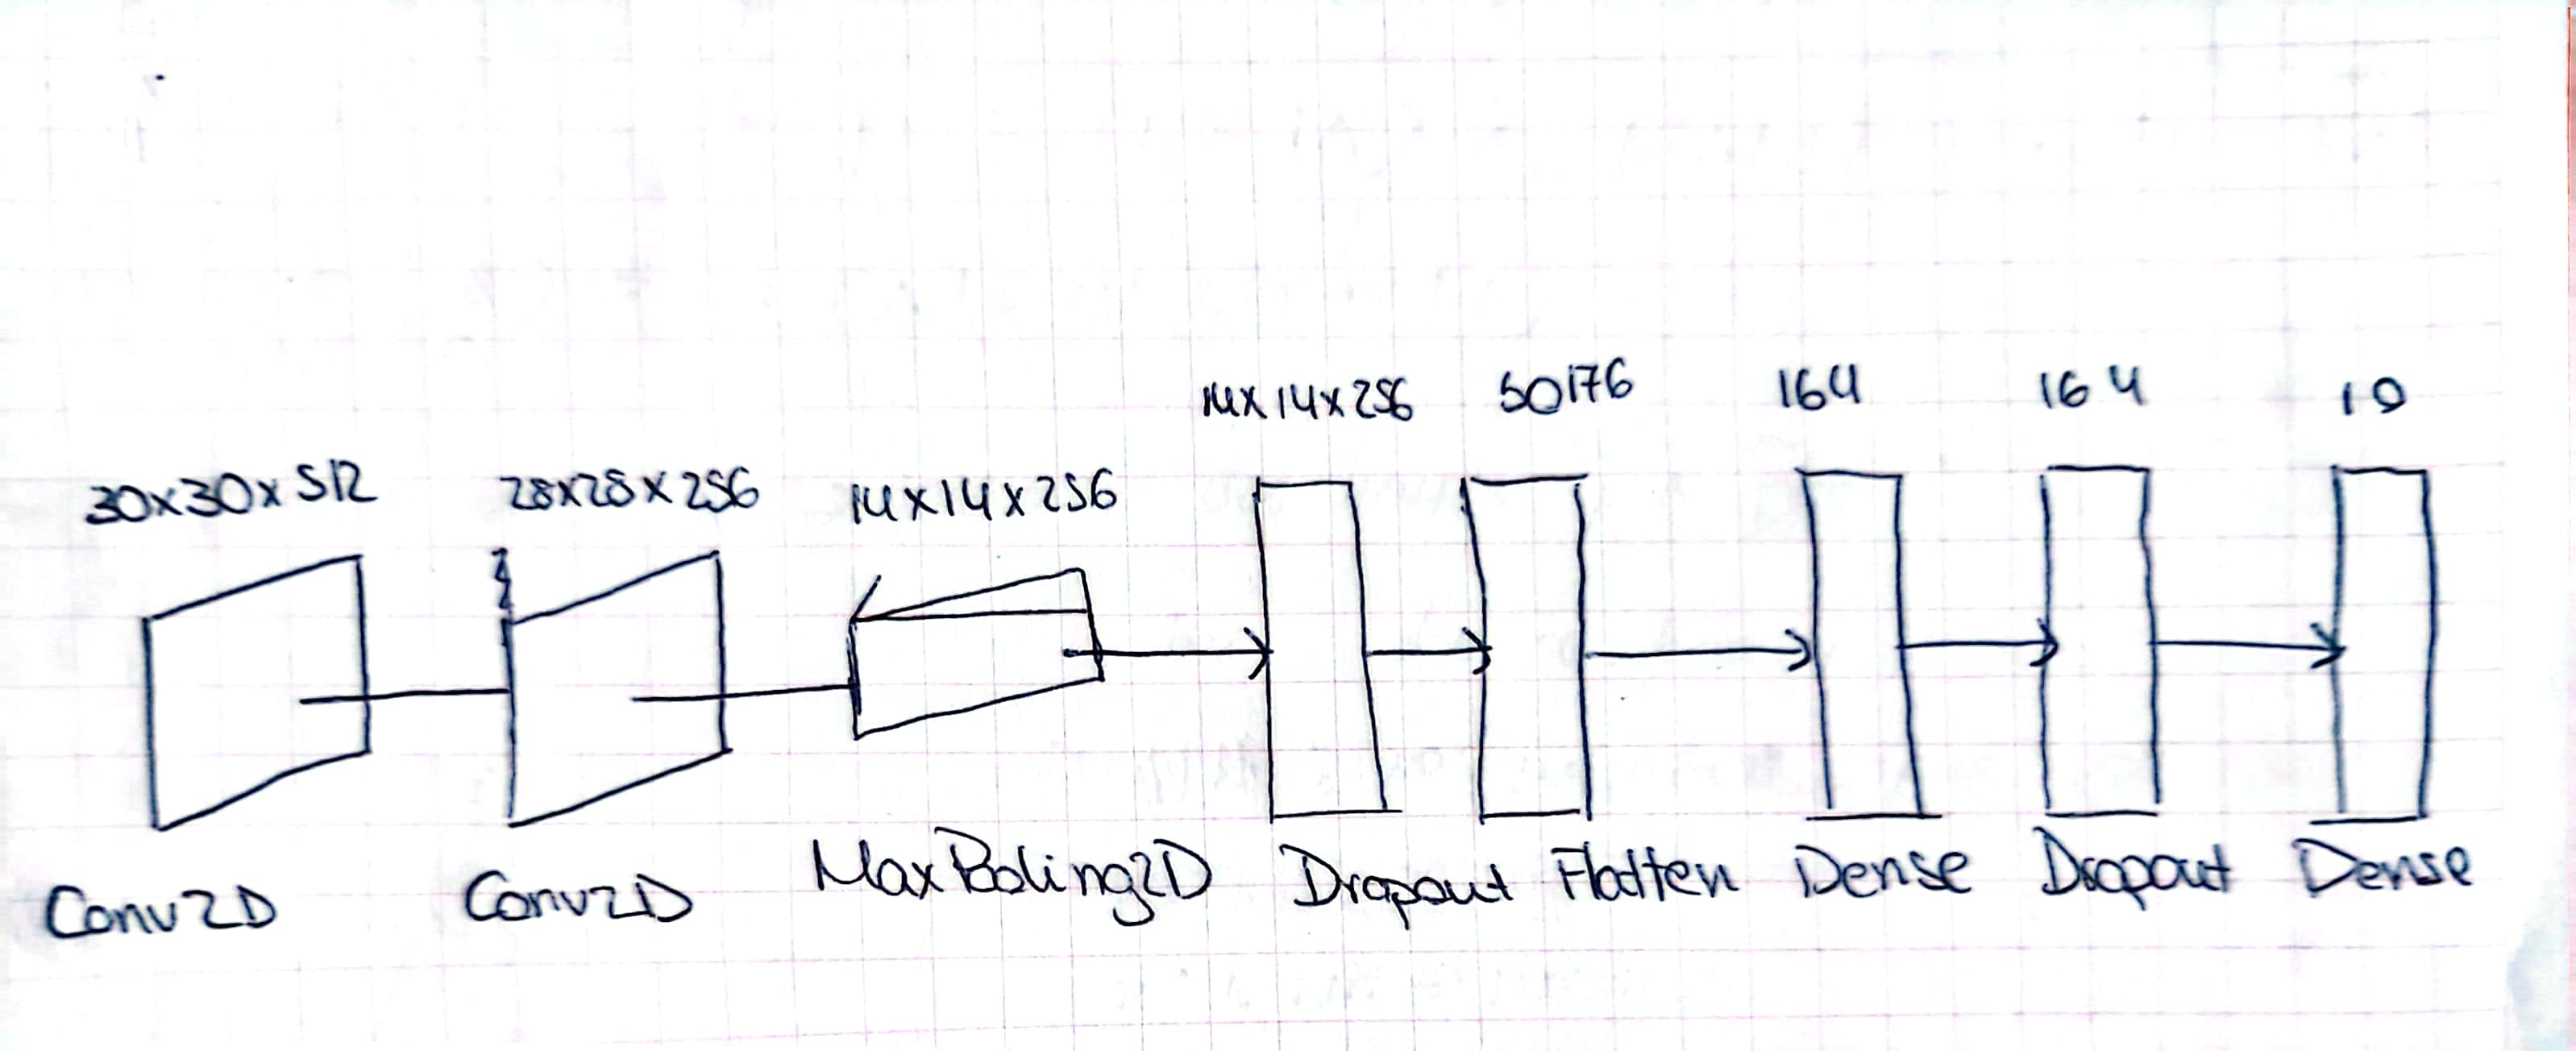



En la figura anterior se indican las distintas capas y dimensiones pertenecientes a la red de la que mejores resultados se han obtenido . A partir del primer Dropout se representa como un rectángulo ya que el MaxPooling se ha ocupado de pasarle los datos en un vector de 1 dimensión.

### 2.    Explica brevemente qué hace cada capa de la red.

La primera capa es una capa convolucional con el número de filtros que se le indica como primer parámetro , tamaño de kernel (3,3) y función de activación que se le pasa como tercer parámetro , por último se le indica el tamaño de la imagen que en este caso es (32, 32, 3).

La segunda capa una capa convolucional igual que la anterior pero con parámetros distintos.

Estas dos capas se ocupan de aplicarle una serie de operaciones a los datos para encontrar los patrones.

La tercera capa es un Max Pooling y de lo que se ocupa es de reducir el tamaño de la imagen por la mitad.

La cuarta capa es de tipo Dropout y sirve para evitar el sobreajuste desechando una parte (0.25) de los datos .

La quinta capa es de tipo Flatten y se encarga de transformar los datos de una estructura 2D a una 1D (un vector) para pasárselo a la siguiente capa.

La sexta capa es una capa neuronal con 164 neuronas y función de asignación indicada en el segundo parámetro.

La séptima capa es otra de tipo Dropout que hace lo mismo que la cuarta.

La última capa es otra neuronal y es la que va a predecir las probabilidades de la clase .

## Entrenamiento

Epoch 1/12
391/391 [==============================] - 46s 90ms/step - loss: 1.6608 - accuracy: 0.4003
Epoch 2/12
391/391 [==============================] - 35s 90ms/step - loss: 1.2885 - accuracy: 0.5442
Epoch 3/12
391/391 [==============================] - 35s 90ms/step - loss: 1.1320 - accuracy: 0.6001
Epoch 4/12
391/391 [==============================] - 35s 89ms/step - loss: 1.0220 - accuracy: 0.6433
Epoch 5/12
391/391 [==============================] - 35s 90ms/step - loss: 0.9416 - accuracy: 0.6702
Epoch 6/12
391/391 [==============================] - 35s 89ms/step - loss: 0.8744 - accuracy: 0.6947
Epoch 7/12
391/391 [==============================] - 35s 90ms/step - loss: 0.8151 - accuracy: 0.7127
Epoch 8/12
391/391 [==============================] - 35s 89ms/step - loss: 0.7635 - accuracy: 0.7350
Epoch 9/12
391/391 [==============================] - 35s 89ms/step - loss: 0.7137 - accuracy: 0.7510
Epoch 10/12
391/391 [==============================] - 35s 89ms/step - loss: 0.675

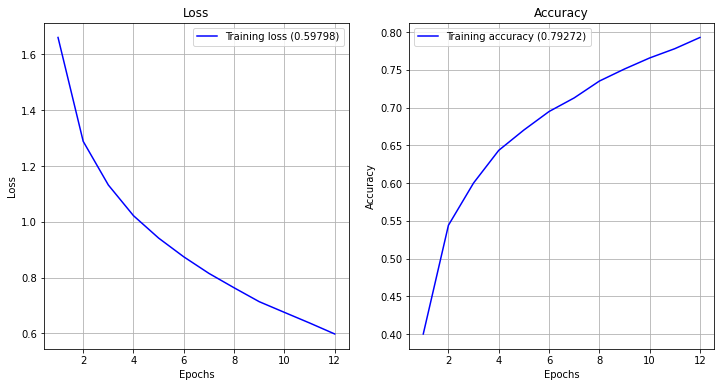

In [ ]:
# Ajuste de los parámetros de la red
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

## Preguntas a responder de la celda anterior

¿Qué diferencias observas en el entrenamiento y en los resultados en comparación con las redes diseñadas en el otro Notebook?

A continuación ejecutaremos el mejor perceptrón multi-capa para el conjunto de datos MNIST sobre CIFAR10.

In [ ]:
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 32, 32
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# reshape data
x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols*3)
x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols*3)

# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
model = Sequential()
model.add(Dense(250, activation='sigmoid', input_shape=(img_rows*img_cols*3,)))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu', input_shape=(img_rows*img_cols*3,)))

model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])
model.summary()

# Ajuste de los parámetros de la red
t0 = time.perf_counter()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=True)
train_time = time.perf_counter() - t0
print('%s %.3f%s' %  ('Training time: ', train_time, 's') )

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

Comparando el resultado de la mejor red con MNIST y CIFAR10 obtenemos que:


*   El valor de accuracy usando CIFAR10 es significativamente más bajo (0.4794999957084656 comparado con 0.9907).
*   El valor de training loss ha aumentado significativamente (para MNIST era de 0.0448 ).
*   Respecto al entrenamiento , si tomamos las mismas iteraciones y el mismo batch size , el entrenamiento de CIFAR10 es un poco más costoso .(para el dataset de MNIST eran 29.421s)




```

RESULTADOS DE LAS REDES CONVOLUCIONALES
(nº capas, nº neuronas, accuracy, técnicas de sobreajuste, etc.)
|CAPAS|    NEURONAS|          F_ACTIVACION|OPTIMIZER|ACURRACY



|----|-------------|--------------- ------|-----|--------------------| 


|8   |128/64/128/10|relu/relu/relu/softmax|Adam |0.7031000256538391 
|8   |256/128/64/10|relu/relu/relu/softmax|Adam |0.7146999835968018 
|8   |400/300/200/10|sigmoid/sigmoid/relu/softmax|Adam |0.010000000149
|8   |256/164/64/10|relu/relu/sigmoid/softmax|Adam |0.7024999856948853 
|8   |512/256/164/10|relu/relu/sigmoid/softmax|Adam |0.7218000292778015 
|8   |600/256/164/10|relu/relu/sigmoid/softma|Adam |0.7110999822616577
|8   |64/32/16/10|relu/relu/sigmoid/softma|Adam |0.6236000061035156
```

De los resultados recopilados en la tabla anterior sobre las redes convolucionales , podemos observar varias cosas:


1.   Si se usa sigmoid como función de activación de la primera capa el valor de accuracy es muy bajo , así que es preferible utilizar relu.
2.   Al llegar a un determinado número de neuronas el accuracy aumenta bastante poco (a partir de los parametros usados en la primera fila). Tampoco sería viable usar un número muy grande de neuronas aunque aumentase el accuracy ya que nos estaríamos acercando a un sobreajuste.



El notebook que entregues deberá incluir:

1.   Modifica la carga de datos, y la configuración inicial de la red si lo ves necesario, para que cargue/utilice el dataset CIFAR10 en lugar de MNIST. Puedes pasar a blanco y negro las imágenes, o hacer que la red trabaje con imagenes en color (n x m x 3), y siempre, normalizar los valores (atributos con valores entre 0 y 1).
2.   Entrena un perceptrón multi-capa y evalúa los resultados que obtiene para CIFAR10. Compara estos resultados con los obtenidos en el dataset anterior (MNIST)
3.   Entrena una red convolucional y evalúa los resultados que obtiene con CIFAR10. Compara estos resultados con los obtenidos para el perceptrón.
4.   Opcional: Repite el último paso, entrenar la red convolucional, utilizando el dataset CIFAR 100, con 100 clases diferentes. En este caso, recuerda asegurarte que el Colab está utilizando una configuración con GPU.

### OPCIONAL

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:

import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
4.8611079500000045
GPU (s):
0.04035838099999012
GPU speedup over CPU: 120x


In [ ]:
# LOAD MNIST
batch_size = 128
num_classes = 100
epochs = 12

# input image dimensions
img_rows, img_cols = 32, 32

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test,  num_classes)

169001437/169001437 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# Definicion de la red convolucional
model = Sequential()
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(164, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 30, 30, 512)       14336     
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 256)       1179904   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 256)       0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 164)               8229028   
                                                        

Epoch 1/12
391/391 [==============================] - 40s 92ms/step - loss: 4.2246 - accuracy: 0.0619
Epoch 2/12
391/391 [==============================] - 35s 89ms/step - loss: 3.6620 - accuracy: 0.1404
Epoch 3/12
391/391 [==============================] - 35s 88ms/step - loss: 3.4174 - accuracy: 0.1851
Epoch 4/12
391/391 [==============================] - 35s 89ms/step - loss: 3.2585 - accuracy: 0.2118
Epoch 5/12
391/391 [==============================] - 34s 88ms/step - loss: 3.1265 - accuracy: 0.2390
Epoch 6/12
391/391 [==============================] - 35s 88ms/step - loss: 2.9991 - accuracy: 0.2635
Epoch 7/12
391/391 [==============================] - 34s 88ms/step - loss: 2.8820 - accuracy: 0.2859
Epoch 8/12
391/391 [==============================] - 34s 88ms/step - loss: 2.7677 - accuracy: 0.3103
Epoch 9/12
391/391 [==============================] - 34s 88ms/step - loss: 2.6698 - accuracy: 0.3253
Epoch 10/12
391/391 [==============================] - 34s 88ms/step - loss: 2.582

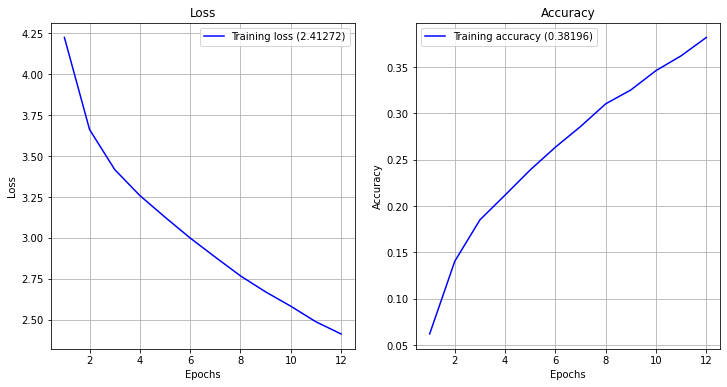

In [ ]:
# Ajuste de los parámetros de la red
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

Comparando los resultados obtenidos aplicando la mejor red red convolucional al dataset de CIFAR100 con los obtenidos para el dataset CIFAR10 para la misma red convolucional y el perceptrón llegamos a las mismas conclusiones.Los valores de accuracy son bastante más bajos (0.36010000109672546 comparado con 0.4794999957084656 y  0.9907) y los valores del loss significativamente altos (2.5134410858154297). Además , si hubiesemos usado la misma configuración de GPU para los dos ,e l último experimento tendría mayor complejidad temporal.


